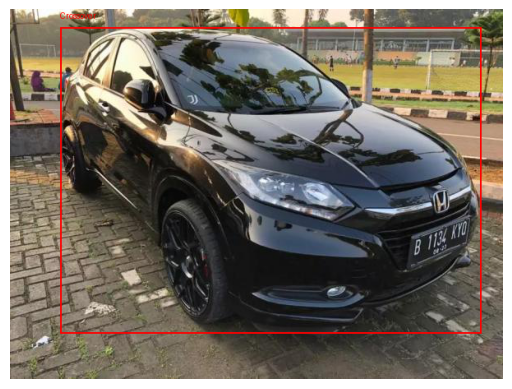

In [2]:
import json
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image_folder_path = 'datasets/indo_car/car' 

annotations_file = 'datasets/indo_car/annotations/annotations1.json' 
with open(annotations_file) as f:
    data = json.load(f)

category_mapping = {
    1: 'Mini SUV',
    2: 'LCGC',
    3: 'MPV',
    4: 'SUV',
    5: 'City Car',
    6: 'Medium SUV',
    7: 'Hatchback',
    8: 'Crossover',
    9: 'Small MPV',
    10: 'Supermini',
}

def load_image(image_filename):
    img = Image.open(os.path.join(image_folder_path, image_filename))
    return img

def draw_bounding_boxes(image, annotations):
    draw = ImageDraw.Draw(image)
    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        
        label = category_mapping.get(category_id, 'Unknown')
        
        draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], outline="red", width=2)
        
        label_position = (bbox[0], bbox[1] - 20) 
        draw.text(label_position, label, fill="red")
    return image

def show_image_with_bboxes(image_id):
    image_info = next(item for item in data['images'] if item['id'] == image_id)
    image_filename = image_info['file_name']
    
    image_annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    
    image = load_image(image_filename)
    
    image_with_bboxes = draw_bounding_boxes(image, image_annotations)
    
    plt.imshow(image_with_bboxes)
    plt.axis('off')
    plt.show()

show_image_with_bboxes(data['images'][237]['id'])


In [3]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

annotations_file = 'datasets/indo_car/annotations/annotations1.json' 
with open(annotations_file, 'r') as f:
    annotations = json.load(f)

category_mapping = {
    1: 'Mini SUV',
    2: 'LCGC',
    3: 'MPV',
    4: 'SUV',
    5: 'City Car',
    6: 'Medium SUV',
    7: 'Hatchback',
    8: 'Crossover',
    9: 'Small MPV',
    10: 'Supermini',
}

class CarDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform
        
        self.image_paths = []
        self.labels = []
        
        for annotation in annotations['images']:

            image_file = annotation['file_name']

            category_ids = [ann['category_id'] for ann in annotations['annotations'] if ann['image_id'] == annotation['id']]
     
            if category_ids:
                self.image_paths.append(image_file)
                self.labels.append(category_ids[0])  
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
    
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert('RGB')
        
        label = self.labels[idx]
        class_name = category_mapping.get(label, 'Unknown')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, class_name


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_directory = 'datasets/indo_car/car' 


car_dataset = CarDataset(annotations, image_directory, transform)
train_loader = DataLoader(car_dataset, batch_size=32, shuffle=True)

for images, labels, class_names in train_loader:
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch shape: {labels}")
    print(f"Class names: {class_names}")
    break


Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: tensor([ 8, 10,  3,  4,  6,  5, 10,  9,  6,  6,  8,  6,  5,  5,  6,  3,  9,  9,
        10,  8,  2,  1,  9, 10,  5,  7, 10,  4,  7,  8,  7,  1])
Class names: ('Crossover', 'Supermini', 'MPV', 'SUV', 'Medium SUV', 'City Car', 'Supermini', 'Small MPV', 'Medium SUV', 'Medium SUV', 'Crossover', 'Medium SUV', 'City Car', 'City Car', 'Medium SUV', 'MPV', 'Small MPV', 'Small MPV', 'Supermini', 'Crossover', 'LCGC', 'Mini SUV', 'Small MPV', 'Supermini', 'City Car', 'Hatchback', 'Supermini', 'SUV', 'Hatchback', 'Crossover', 'Hatchback', 'Mini SUV')


In [ ]:
import torch.optim as optim
import torch.nn as nn
from torchvision import models

# Initialize VGG16 model pre-trained on ImageNet
model = models.vgg16(pretrained=True)

# Modify the final layer to match the number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(category_mapping))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels, _ in train_loader: 
        images, labels = images.to(device), labels.to(device)
        
        labels = labels - 1 
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1) 
        correct_predictions += (predicted == labels).sum().item()  
        total_predictions += labels.size(0)  
        
        running_loss += loss.item()
    
    accuracy = (correct_predictions / total_predictions) * 100
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 2.3012, Accuracy: 13.00%
Epoch [2/10], Loss: 2.0104, Accuracy: 30.75%
Epoch [3/10], Loss: 1.3632, Accuracy: 52.25%
Epoch [4/10], Loss: 0.6694, Accuracy: 77.25%
Epoch [5/10], Loss: 0.2174, Accuracy: 93.75%
Epoch [6/10], Loss: 0.1283, Accuracy: 95.75%
Epoch [7/10], Loss: 0.0300, Accuracy: 99.25%
Epoch [8/10], Loss: 0.0435, Accuracy: 98.25%
Epoch [9/10], Loss: 0.0366, Accuracy: 98.75%
Epoch [10/10], Loss: 0.0257, Accuracy: 99.25%


In [36]:
torch.save(model.state_dict(), 'car_classification_model.pth')

In [7]:
import torch
from torchvision import models
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load VGG16
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(category_mapping))

# Load trained weights
model.load_state_dict(torch.load("car_classification_model.pth", map_location=device))
model = model.to(device)
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

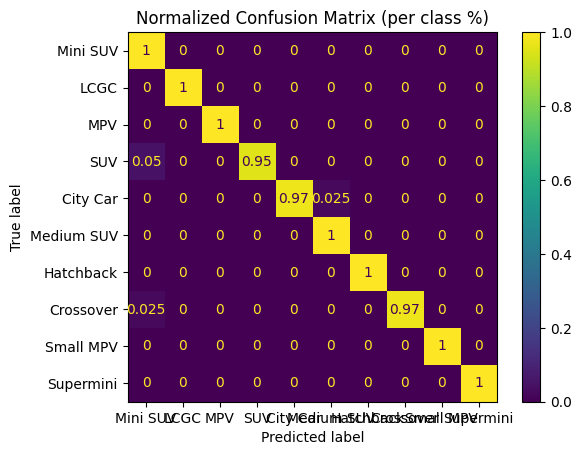

[[100.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.  100.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.  100.    0.    0.    0.    0.    0.    0.    0. ]
 [  5.    0.    0.   95.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.   97.5   2.5   0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.  100.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.  100.    0.    0.    0. ]
 [  2.5   0.    0.    0.    0.    0.    0.   97.5   0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.  100.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.  100. ]]


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in train_loader:  # atau valid_loader
        images, labels = images.to(device), labels.to(device)
        labels = labels - 1  # jika perlu
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(category_mapping.values()))
disp.plot(cmap=plt.cm.viridis)

plt.title("Normalized Confusion Matrix (per class %)")
plt.show()

print((cm * 100).round(2))
